In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingLR
import time
import matplotlib.pyplot as plt
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.manual_seed(5)
np.random.seed(5)

Using device: cuda


In [ ]:
class Sine(nn.Module):
    def forward(self, input):
        return torch.sin(input)


class PINN40(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(4, 40), nn.Tanh(),
        nn.Linear(40, 40), nn.Tanh(),
        nn.Linear(40, 40), nn.Tanh(),
        nn.Linear(40, 40), nn.Tanh(),
        nn.Linear(40, 1)
    )
  def forward(self, x, mu):
    return self.net(torch.cat((x, mu), dim=1))

class PINN60(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(4, 60), nn.Tanh(),
        nn.Linear(60, 60), nn.Tanh(),
        nn.Linear(60, 60), nn.Tanh(),
        nn.Linear(60, 60), nn.Tanh(),
        nn.Linear(60, 1)
    )
  def forward(self, x, mu):
    return self.net(torch.cat((x, mu), dim=1))

class PINN80(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(4, 80), nn.Tanh(),
        nn.Linear(80, 80), nn.Tanh(),
        nn.Linear(80, 80), nn.Tanh(),
        nn.Linear(80, 80), nn.Tanh(),
        nn.Linear(80, 1)
    )
  def forward(self, x, mu):
    return self.net(torch.cat((x, mu), dim=1))

class PINN128(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(4, 128), nn.Tanh(),
        nn.Linear(128, 128), nn.Tanh(),
        nn.Linear(128, 128), nn.Tanh(),
        nn.Linear(128, 128), nn.Tanh(),
        nn.Linear(128, 1)
    )
  def forward(self, x, mu):
    return self.net(torch.cat((x, mu), dim=1))

class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim), nn.Tanh(),
            nn.Linear(dim, dim)
        )
    def forward(self, x):
        return x + self.block(x)

class PINNResNet(nn.Module):
    def __init__(self, hidden_dim=60, num_blocks=4):
        super().__init__()
        self.input = nn.Linear(4, hidden_dim)
        self.blocks = nn.Sequential(*[ResBlock(hidden_dim) for _ in range(num_blocks)])
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, x, mu):
        z = torch.cat((x, mu), dim=1)
        z = torch.tanh(self.input(z))
        z = self.blocks(z)
        return self.out(z)

class PINN_Tanh_Deep(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [nn.Linear(4, 40), nn.Tanh()]
        for _ in range(7):
            layers += [nn.Linear(40, 40), nn.Tanh()]
        layers.append(nn.Linear(40, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x, mu):
        return self.net(torch.cat((x, mu), dim=1))

class PINN_ReLU_60(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 60), nn.ReLU(),
            nn.Linear(60, 60), nn.ReLU(),
            nn.Linear(60, 60), nn.ReLU(),
            nn.Linear(60, 60), nn.ReLU(),
            nn.Linear(60, 1)
        )

    def forward(self, x, mu):
        return self.net(torch.cat((x, mu), dim=1))

class PINN_SiLU_60(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 60), nn.SiLU(),
            nn.Linear(60, 60), nn.SiLU(),
            nn.Linear(60, 60), nn.SiLU(),
            nn.Linear(60, 60), nn.SiLU(),
            nn.Linear(60, 1)
        )

    def forward(self, x, mu):
        return self.net(torch.cat((x, mu), dim=1))

class PINN_Sine_60(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 60), Sine(),
            nn.Linear(60, 60), Sine(),
            nn.Linear(60, 60), Sine(),
            nn.Linear(60, 60), Sine(),
            nn.Linear(60, 1)
        )

    def forward(self, x, mu):
        return self.net(torch.cat((x, mu), dim=1))

class PINN_ELU_60(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 60), nn.ELU(),
            nn.Linear(60, 60), nn.ELU(),
            nn.Linear(60, 60), nn.ELU(),
            nn.Linear(60, 60), nn.ELU(),
            nn.Linear(60, 1)
        )

    def forward(self, x, mu):
        return self.net(torch.cat((x, mu), dim=1))

class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim), nn.Tanh(),
            nn.Linear(dim, dim)
        )
    def forward(self, x):
        return x + self.block(x)

class PINN_ResNet60(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(4, 60)
        self.blocks = nn.Sequential(
            ResBlock(60),
            ResBlock(60),
            ResBlock(60),
            ResBlock(60)
        )
        self.output = nn.Linear(60, 1)

    def forward(self, x, mu):
        z = torch.cat((x, mu), dim=1)
        z = torch.tanh(self.input(z))
        z = self.blocks(z)
        return self.output(z)

class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim), nn.Tanh(),
            nn.Linear(dim, dim)
        )
    def forward(self, x):
        return x + self.block(x)

class PINN_ResNet60(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(4, 60)
        self.blocks = nn.Sequential(
            ResBlock(60),
            ResBlock(60),
            ResBlock(60),
            ResBlock(60)
        )
        self.output = nn.Linear(60, 1)

    def forward(self, x, mu):
        z = torch.cat((x, mu), dim=1)
        z = torch.tanh(self.input(z))
        z = self.blocks(z)
        return self.output(z)

class PINN_LN_60(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 60), nn.LayerNorm(60), nn.Tanh(),
            nn.Linear(60, 60), nn.LayerNorm(60), nn.Tanh(),
            nn.Linear(60, 60), nn.LayerNorm(60), nn.Tanh(),
            nn.Linear(60, 60), nn.LayerNorm(60), nn.Tanh(),
            nn.Linear(60, 1)
        )

    def forward(self, x, mu):
        return self.net(torch.cat((x, mu), dim=1))

class PINN_MixAct(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 60), nn.Tanh(),
            nn.Linear(60, 60), nn.ReLU(),
            nn.Linear(60, 60), nn.Tanh(),
            nn.Linear(60, 60), nn.ReLU(),
            nn.Linear(60, 1)
        )

    def forward(self, x, mu):
        return self.net(torch.cat((x, mu), dim=1))


In [4]:
def generate_data(N_domain=1750, N_boundary=150):
    # Points in the domain
    x_in = torch.rand((N_domain, 2))  # [x0, x1] ∈ Ω
    mu_in = (torch.rand((1, 2)) * 0.9 + 0.1).expand(N_domain, -1) # [mu0, mu1] ∈ [0.1, 1]^2

    # Points on the border of the domain (edge of the square)
    x0 = torch.rand(N_boundary, 1)
    zeros = torch.zeros_like(x0)
    ones = torch.ones_like(x0)

    xb = torch.cat([
        torch.cat([x0, zeros], dim=1),
        torch.cat([x0, ones], dim=1),
        torch.cat([zeros, x0], dim=1),
        torch.cat([ones, x0], dim=1)
    ], dim=0)

    mu_b = mu_in[:N_boundary*4, :]
    return x_in, mu_in, xb, mu_b

In [ ]:
# x: [N, 2], mu: [N, 2]
def R(x, mu, net):
    x.requires_grad_(True)
    mu.requires_grad_(False)

    u = net(x, mu)  # output shape: [N, 1]

    # ∇u (du/dx e du/dy)
    grads = torch.autograd.grad(u.sum(), x, create_graph=True)[0]  # shape [N, 2]
    u_x = grads[:, 0].unsqueeze(1)  # du/dx
    u_y = grads[:, 1].unsqueeze(1)  # du/dy

    # Laplacian = d²u/dx² + d²u/dy²
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0][:, 0].unsqueeze(1)
    u_yy = torch.autograd.grad(u_y.sum(), x, create_graph=True)[0][:, 1].unsqueeze(1)
    laplacian_u = u_xx + u_yy

    # Nonlinear term
    mu0 = mu[:, 0].unsqueeze(1)
    mu1 = mu[:, 1].unsqueeze(1)
    nonlinear = (mu0 / mu1) * (torch.exp(mu1 * u) - 1)

    # Forcing term g(x)
    x0 = x[:, 0].unsqueeze(1)
    x1 = x[:, 1].unsqueeze(1)
    g = 100 * torch.sin(2 * torch.pi * x0) * torch.cos(2 * torch.pi * x1)

    # Residuo della PDE
    residual = -laplacian_u + nonlinear - g

    return residual

def adaptive_sample(model, N_tot=5000, N_sel=1750, N_boundary=150):
    X = torch.rand(N_tot, 2, device=device)
    M = (torch.rand(N_tot, 2, device=device) * 0.9 + 0.1)

    X.requires_grad_(True)
    R_vals = R(X, M, model).detach().abs().cpu().numpy().flatten()  

    idx = np.argsort(R_vals)[-N_sel:]
    x_int = X.detach()[idx]
    mu_int = M.detach()[idx]

    x0 = torch.rand(N_boundary, 1, device=device)
    zeros = torch.zeros_like(x0)
    ones = torch.ones_like(x0)
    xb = torch.cat([
        torch.cat([x0, zeros], 1),
        torch.cat([x0, ones], 1),
        torch.cat([zeros, x0], 1),
        torch.cat([ones, x0], 1)
    ], 0)
    mu_b = (torch.rand(1, 2, device=device) * 0.9 + 0.1).expand(xb.shape[0], -1)

    return x_int, mu_int, xb, mu_b

In [6]:
def train_plot(model, epochs=50000, lr=1e-3, lambda_bc=1.0, patience=7500, delta=1e-4, batch_size=None, save_path="./models"):
    os.makedirs(save_path, exist_ok=True)

    model.to(device)
    mse_loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_phys_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0
    using_lbfgs = False

    loss_history_total = []
    loss_history_phys = []
    loss_history_bc = []
    times_per_epoch = []

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        x_in, mu_in, xb, mu_b = generate_data()

        if epoch != 0:
            x_in, mu_in, xb, mu_b = adaptive_sample(model)

        x_in = x_in.to(device)
        mu_in = mu_in.to(device)
        xb = xb.to(device)
        mu_b = mu_b.to(device)

        try:
            if not using_lbfgs:
                optimizer.zero_grad()
                loss_phys = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))
                u_b = model(xb, mu_b)
                loss_bc = mse_loss(u_b, torch.zeros_like(u_b))

                loss_total = loss_phys + lambda_bc * loss_bc

                if torch.isnan(loss_total):
                    raise ValueError("NaN detected in Adam loss computation")

                loss_total.backward()
                optimizer.step()

                if loss_phys.item() + delta < best_phys_loss:
                    best_phys_loss = loss_phys.item()
                    best_model_state = model.state_dict()
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

                if loss_bc.item() < 1e-1 and loss_phys.item() < 1e-1:
                    print(f"\nSwitching to LBFGS at epoch {epoch}")
                    using_lbfgs = True
                    optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=500)
                    if best_model_state:
                        model.load_state_dict(best_model_state)

            else:
                def closure():
                    optimizer.zero_grad()
                    loss_phys_cl = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))
                    u_b_cl = model(xb, mu_b)
                    loss_bc_cl = mse_loss(u_b_cl, torch.zeros_like(u_b_cl))
                    loss_total_cl = loss_phys_cl + lambda_bc * loss_bc_cl

                    if torch.isnan(loss_total_cl):
                        raise ValueError("NaN detected in LBFGS loss computation")

                    loss_total_cl.backward()
                    return loss_total_cl

                optimizer.step(closure)

                loss_phys = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))
                u_b = model(xb, mu_b)
                loss_bc = mse_loss(u_b, torch.zeros_like(u_b))
                loss_total = loss_phys + lambda_bc * loss_bc

        except ValueError as e:
            print(f"\n❌ Training stopped due to error at epoch {epoch}: {str(e)}")
            if best_model_state:
                print("🔄 Reverting to best model state before NaN.")
                model.load_state_dict(best_model_state)
                torch.save(model.state_dict(), os.path.join(save_path, f"model_nan_epoch{epoch}.pth"))
            break

        loss_history_total.append(loss_total.item())
        loss_history_phys.append(loss_phys.item())
        loss_history_bc.append(loss_bc.item())
        times_per_epoch.append(time.time() - start_time)

        if epoch % 500 == 0 or epoch == epochs - 1:
            opt_name = "Adam"
            print(f"[{opt_name}] Epoch {epoch} - Total: {loss_total.item():.2e} | PDE: {loss_phys.item():.2e} | BC: {loss_bc.item():.2e}")

        if using_lbfgs and epoch % 1 == 0 or epoch == epochs - 1:
            opt_name = "LBFGS"
            print(f"[{opt_name}] Epoch {epoch} - Total: {loss_total.item():.2e} | PDE: {loss_phys.item():.2e} | BC: {loss_bc.item():.2e}")

        if not using_lbfgs and epochs_no_improve >= patience:
            print(f"\n🛑 Early stopping at epoch {epoch} | Best PDE loss: {best_phys_loss:.2e}")
            model.load_state_dict(best_model_state)
            torch.save(model.state_dict(), os.path.join(save_path, "model_best.pth"))
            break

    torch.save(model.state_dict(), os.path.join(save_path, "model_final.pth"))

    plt.figure(figsize=(10, 5))
    plt.plot(loss_history_total, label='Total Loss')
    plt.plot(loss_history_phys, label='PDE Loss')
    plt.plot(loss_history_bc, label='BC Loss')
    plt.yscale('log')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss trends over training")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    total_epochs = len(loss_history_total)
    avg_time = sum(times_per_epoch) / total_epochs
    print(f"\n✅ Training complete: {total_epochs} epochs")
    print(f"⏱ Average time per epoch: {avg_time:.4f} seconds")

    return {
        "loss_total": loss_history_total,
        "loss_phys": loss_history_phys,
        "loss_bc": loss_history_bc,
        "times_per_epoch": times_per_epoch,
        "avg_time": avg_time,
        "epochs": total_epochs
    }


[Adam] Epoch 0 - Total: 2.47e+03 | PDE: 2.47e+03 | BC: 1.88e-02
[Adam] Epoch 500 - Total: 5.64e+02 | PDE: 5.56e+02 | BC: 8.32e+00
[Adam] Epoch 1000 - Total: 2.04e+01 | PDE: 1.29e+01 | BC: 7.47e+00
[Adam] Epoch 1500 - Total: 8.40e+00 | PDE: 3.61e+00 | BC: 4.79e+00
[Adam] Epoch 2000 - Total: 4.70e+00 | PDE: 1.70e+00 | BC: 3.00e+00
[Adam] Epoch 2500 - Total: 3.22e+00 | PDE: 1.25e+00 | BC: 1.97e+00
[Adam] Epoch 3000 - Total: 2.11e+00 | PDE: 7.88e-01 | BC: 1.32e+00
[Adam] Epoch 3500 - Total: 1.50e+00 | PDE: 4.78e-01 | BC: 1.02e+00
[Adam] Epoch 4000 - Total: 1.30e+00 | PDE: 5.03e-01 | BC: 8.01e-01
[Adam] Epoch 4500 - Total: 1.07e+00 | PDE: 3.55e-01 | BC: 7.17e-01
[Adam] Epoch 5000 - Total: 9.50e-01 | PDE: 2.64e-01 | BC: 6.86e-01
[Adam] Epoch 5500 - Total: 8.41e-01 | PDE: 2.20e-01 | BC: 6.21e-01
[Adam] Epoch 6000 - Total: 8.81e-01 | PDE: 2.48e-01 | BC: 6.33e-01
[Adam] Epoch 6500 - Total: 8.09e-01 | PDE: 2.94e-01 | BC: 5.15e-01
[Adam] Epoch 7000 - Total: 8.03e-01 | PDE: 3.15e-01 | BC: 4.88e-01

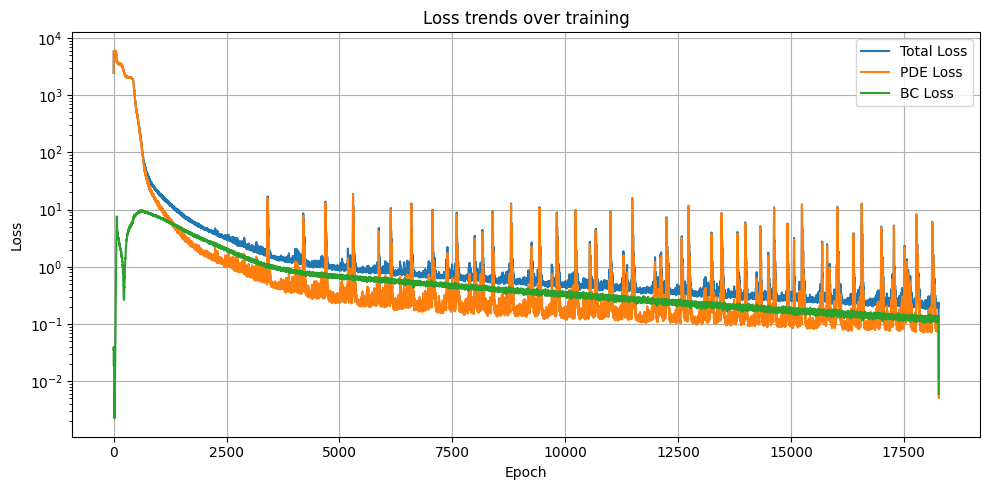


✅ Training complete: 18275 epochs
⏱ Average time per epoch: 0.0153 seconds


In [7]:
# 1
PINN40 = PINN40().to(device)
train_plot(PINN40, epochs = 50000)

torch.save(PINN40.state_dict(), "PINN40.pth")

[Adam] Epoch 0 - Total: 2.46e+03 | PDE: 2.46e+03 | BC: 7.25e-04
[Adam] Epoch 500 - Total: 5.37e+01 | PDE: 4.36e+01 | BC: 1.01e+01
[Adam] Epoch 1000 - Total: 1.27e+01 | PDE: 5.65e+00 | BC: 7.01e+00
[Adam] Epoch 1500 - Total: 5.65e+00 | PDE: 2.72e+00 | BC: 2.93e+00
[Adam] Epoch 2000 - Total: 3.45e+00 | PDE: 1.60e+00 | BC: 1.85e+00
[Adam] Epoch 2500 - Total: 2.06e+00 | PDE: 6.76e-01 | BC: 1.38e+00
[Adam] Epoch 3000 - Total: 1.87e+00 | PDE: 6.55e-01 | BC: 1.21e+00
[Adam] Epoch 3500 - Total: 1.46e+00 | PDE: 4.51e-01 | BC: 1.01e+00
[Adam] Epoch 4000 - Total: 1.30e+00 | PDE: 3.89e-01 | BC: 9.08e-01
[Adam] Epoch 4500 - Total: 1.13e+00 | PDE: 3.12e-01 | BC: 8.21e-01
[Adam] Epoch 5000 - Total: 1.03e+00 | PDE: 3.94e-01 | BC: 6.36e-01
[Adam] Epoch 5500 - Total: 7.23e-01 | PDE: 2.11e-01 | BC: 5.13e-01
[Adam] Epoch 6000 - Total: 8.67e-01 | PDE: 3.65e-01 | BC: 5.02e-01
[Adam] Epoch 6500 - Total: 6.09e-01 | PDE: 2.31e-01 | BC: 3.78e-01
[Adam] Epoch 7000 - Total: 5.51e-01 | PDE: 1.94e-01 | BC: 3.56e-01

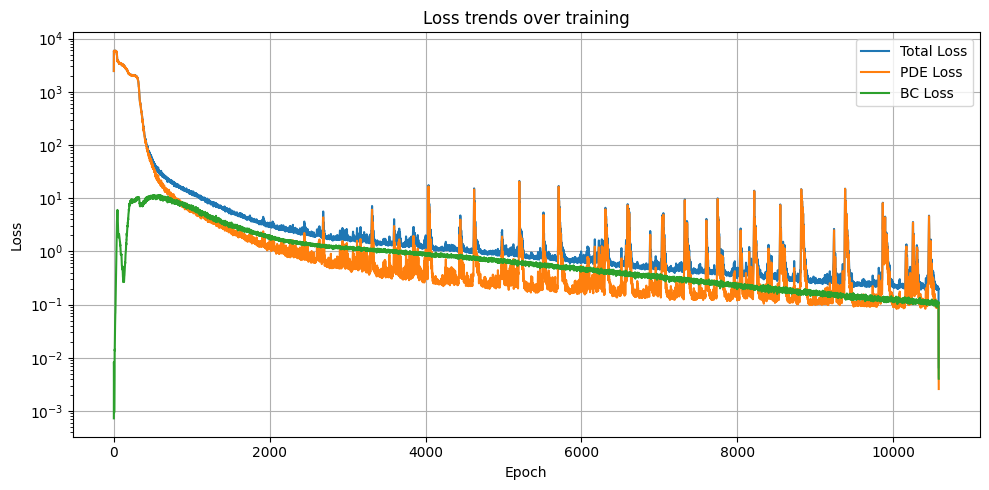


✅ Training complete: 10588 epochs
⏱ Average time per epoch: 0.0165 seconds


In [8]:
# 2
PINN60 = PINN60().to(device)
train_plot(PINN60, epochs = 50000)

torch.save(PINN60.state_dict(), "PINN60.pth")

[Adam] Epoch 0 - Total: 2.44e+03 | PDE: 2.44e+03 | BC: 2.67e-03
[Adam] Epoch 500 - Total: 6.69e+00 | PDE: 4.41e+00 | BC: 2.28e+00
[Adam] Epoch 1000 - Total: 4.08e+00 | PDE: 1.88e+00 | BC: 2.20e+00
[Adam] Epoch 1500 - Total: 2.72e+00 | PDE: 8.52e-01 | BC: 1.87e+00
[Adam] Epoch 2000 - Total: 2.48e+00 | PDE: 7.55e-01 | BC: 1.72e+00
[Adam] Epoch 2500 - Total: 2.11e+00 | PDE: 5.90e-01 | BC: 1.52e+00
[Adam] Epoch 3000 - Total: 1.70e+00 | PDE: 2.84e-01 | BC: 1.41e+00
[Adam] Epoch 3500 - Total: 1.45e+00 | PDE: 1.96e-01 | BC: 1.26e+00
[Adam] Epoch 4000 - Total: 1.35e+00 | PDE: 1.69e-01 | BC: 1.18e+00
[Adam] Epoch 4500 - Total: 1.31e+00 | PDE: 3.02e-01 | BC: 1.01e+00
[Adam] Epoch 5000 - Total: 9.65e-01 | PDE: 1.35e-01 | BC: 8.30e-01
[Adam] Epoch 5500 - Total: 2.31e+00 | PDE: 1.50e+00 | BC: 8.08e-01
[Adam] Epoch 6000 - Total: 9.38e-01 | PDE: 3.00e-01 | BC: 6.38e-01
[Adam] Epoch 6500 - Total: 7.97e-01 | PDE: 2.60e-01 | BC: 5.37e-01
[Adam] Epoch 7000 - Total: 5.79e-01 | PDE: 1.23e-01 | BC: 4.57e-01

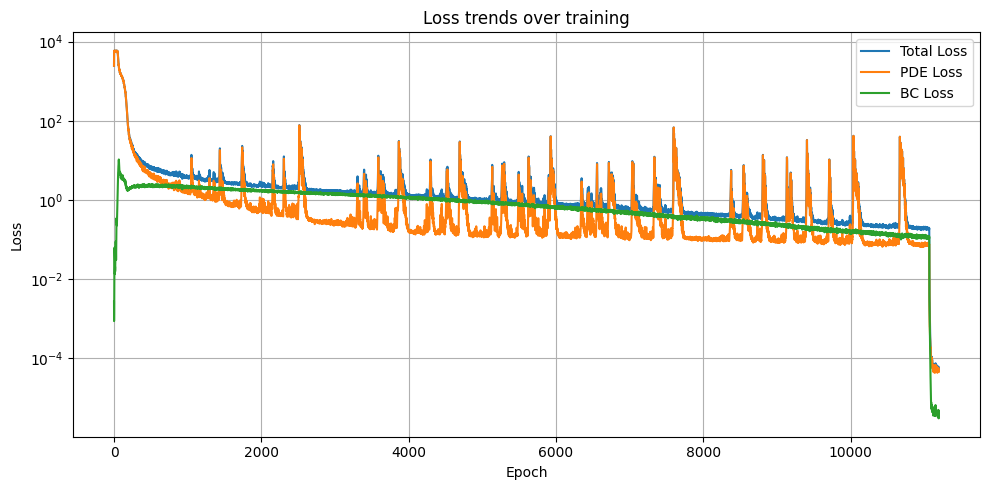


✅ Training complete: 11197 epochs
⏱ Average time per epoch: 0.0875 seconds


In [9]:
# 3
PINN80 = PINN80().to(device)
train_plot(PINN80, epochs = 50000)

torch.save(PINN80.state_dict(), "PINN80.pth")

[Adam] Epoch 0 - Total: 2.44e+03 | PDE: 2.44e+03 | BC: 9.58e-03
[Adam] Epoch 500 - Total: 1.68e+01 | PDE: 7.89e+00 | BC: 8.89e+00
[Adam] Epoch 1000 - Total: 7.91e+00 | PDE: 2.14e+00 | BC: 5.77e+00
[Adam] Epoch 1500 - Total: 5.36e+00 | PDE: 2.26e+00 | BC: 3.10e+00
[Adam] Epoch 2000 - Total: 5.13e+00 | PDE: 3.76e+00 | BC: 1.37e+00
[Adam] Epoch 2500 - Total: 1.28e+00 | PDE: 6.45e-01 | BC: 6.31e-01
[Adam] Epoch 3000 - Total: 7.52e-01 | PDE: 3.38e-01 | BC: 4.14e-01
[Adam] Epoch 3500 - Total: 2.09e+00 | PDE: 1.78e+00 | BC: 3.12e-01
[Adam] Epoch 4000 - Total: 5.24e-01 | PDE: 2.11e-01 | BC: 3.13e-01
[Adam] Epoch 4500 - Total: 4.85e-01 | PDE: 2.06e-01 | BC: 2.79e-01
[Adam] Epoch 5000 - Total: 3.95e-01 | PDE: 1.48e-01 | BC: 2.47e-01
[Adam] Epoch 5500 - Total: 1.77e+00 | PDE: 1.57e+00 | BC: 2.00e-01
[Adam] Epoch 6000 - Total: 8.44e-01 | PDE: 6.53e-01 | BC: 1.92e-01
[Adam] Epoch 6500 - Total: 5.26e-01 | PDE: 3.50e-01 | BC: 1.76e-01
[Adam] Epoch 7000 - Total: 4.00e+00 | PDE: 3.85e+00 | BC: 1.51e-01

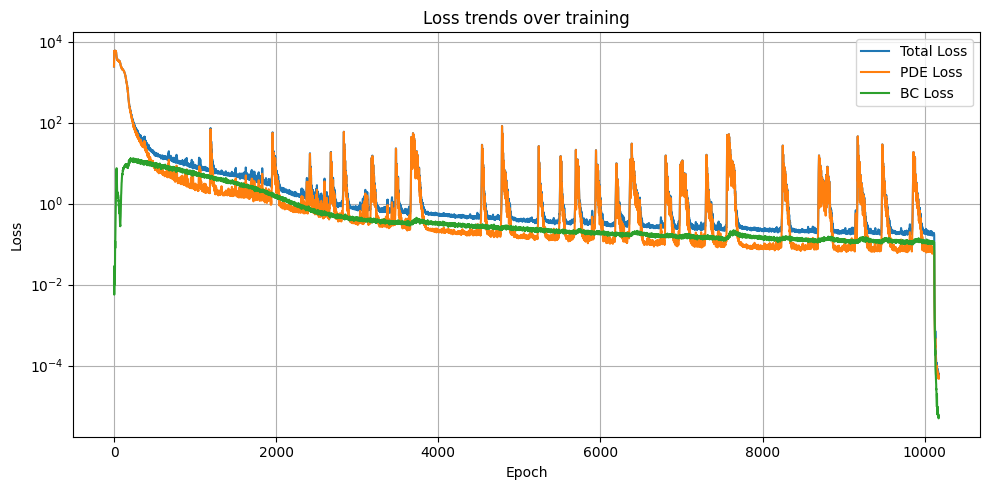


✅ Training complete: 10174 epochs
⏱ Average time per epoch: 0.0575 seconds


In [10]:
# 4
PINN128 = PINN128().to(device)
train_plot(PINN128, epochs = 50000)

torch.save(PINN128.state_dict(), "PINN128.pth")

[Adam] Epoch 0 - Total: 2.48e+03 | PDE: 2.48e+03 | BC: 6.28e-03
[Adam] Epoch 500 - Total: 9.73e+00 | PDE: 7.13e+00 | BC: 2.60e+00
[Adam] Epoch 1000 - Total: 4.86e+00 | PDE: 3.19e+00 | BC: 1.68e+00
[Adam] Epoch 1500 - Total: 3.37e+00 | PDE: 1.68e+00 | BC: 1.69e+00
[Adam] Epoch 2000 - Total: 2.75e+00 | PDE: 1.19e+00 | BC: 1.56e+00
[Adam] Epoch 2500 - Total: 1.60e+01 | PDE: 1.46e+01 | BC: 1.45e+00
[Adam] Epoch 3000 - Total: 2.07e+00 | PDE: 7.72e-01 | BC: 1.29e+00
[Adam] Epoch 3500 - Total: 1.83e+00 | PDE: 5.71e-01 | BC: 1.26e+00
[Adam] Epoch 4000 - Total: 1.82e+00 | PDE: 7.05e-01 | BC: 1.11e+00
[Adam] Epoch 4500 - Total: 2.85e+00 | PDE: 1.78e+00 | BC: 1.06e+00
[Adam] Epoch 5000 - Total: 1.31e+00 | PDE: 3.30e-01 | BC: 9.79e-01
[Adam] Epoch 5500 - Total: 1.29e+00 | PDE: 4.15e-01 | BC: 8.79e-01
[Adam] Epoch 6000 - Total: 3.37e+00 | PDE: 2.50e+00 | BC: 8.75e-01
[Adam] Epoch 6500 - Total: 1.35e+00 | PDE: 5.28e-01 | BC: 8.26e-01
[Adam] Epoch 7000 - Total: 9.16e-01 | PDE: 2.18e-01 | BC: 6.98e-01

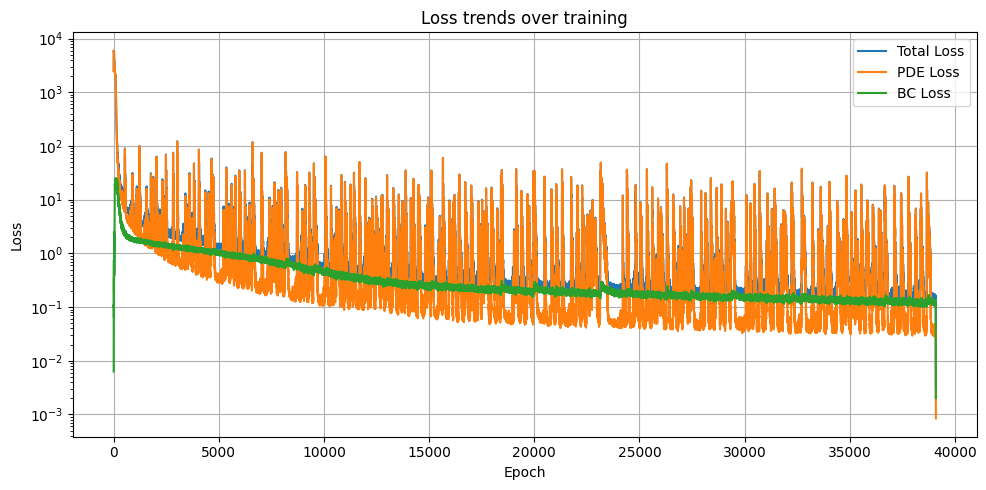


✅ Training complete: 39093 epochs
⏱ Average time per epoch: 0.0223 seconds


In [11]:
# 6
PINNResNet = PINNResNet().to(device)
train_plot(PINNResNet, epochs = 50000)

torch.save(PINNResNet.state_dict(), "PINNResNet.pth")

[Adam] Epoch 0 - Total: 2.43e+03 | PDE: 2.43e+03 | BC: 6.35e-04
[Adam] Epoch 500 - Total: 1.46e+03 | PDE: 1.45e+03 | BC: 9.94e+00
[Adam] Epoch 1000 - Total: 2.55e+01 | PDE: 1.61e+01 | BC: 9.44e+00
[Adam] Epoch 1500 - Total: 1.40e+01 | PDE: 8.44e+00 | BC: 5.61e+00
[Adam] Epoch 2000 - Total: 6.02e+00 | PDE: 2.68e+00 | BC: 3.34e+00
[Adam] Epoch 2500 - Total: 3.63e+00 | PDE: 1.47e+00 | BC: 2.16e+00
[Adam] Epoch 3000 - Total: 2.60e+00 | PDE: 1.12e+00 | BC: 1.48e+00
[Adam] Epoch 3500 - Total: 1.88e+00 | PDE: 6.04e-01 | BC: 1.28e+00
[Adam] Epoch 4000 - Total: 1.80e+00 | PDE: 6.07e-01 | BC: 1.19e+00
[Adam] Epoch 4500 - Total: 6.56e+00 | PDE: 5.43e+00 | BC: 1.13e+00
[Adam] Epoch 5000 - Total: 1.20e+00 | PDE: 3.37e-01 | BC: 8.62e-01
[Adam] Epoch 5500 - Total: 1.15e+00 | PDE: 3.38e-01 | BC: 8.15e-01
[Adam] Epoch 6000 - Total: 1.85e+00 | PDE: 1.12e+00 | BC: 7.33e-01
[Adam] Epoch 6500 - Total: 9.57e-01 | PDE: 3.08e-01 | BC: 6.49e-01
[Adam] Epoch 7000 - Total: 1.14e+00 | PDE: 5.72e-01 | BC: 5.69e-01

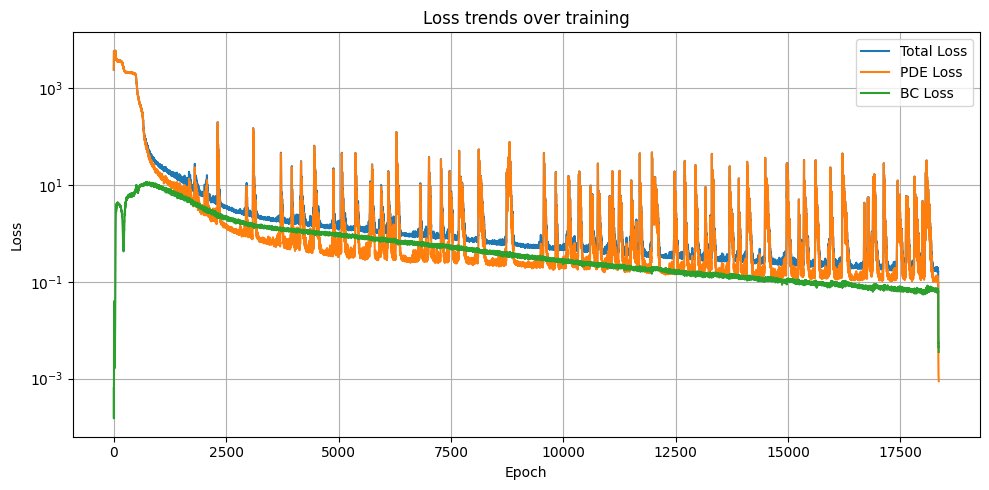


✅ Training complete: 18356 epochs
⏱ Average time per epoch: 0.0301 seconds


In [12]:
# 7
PINN_Tanh_Deep = PINN_Tanh_Deep().to(device)
train_plot(PINN_Tanh_Deep, epochs = 50000)

torch.save(PINN_Tanh_Deep.state_dict(), "PINN_Tanh_Deep.pth")

[Adam] Epoch 0 - Total: 2.58e+03 | PDE: 2.58e+03 | BC: 7.78e-03
[Adam] Epoch 500 - Total: 3.75e+03 | PDE: 3.67e+03 | BC: 7.97e+01
[Adam] Epoch 1000 - Total: 3.50e+03 | PDE: 3.45e+03 | BC: 5.23e+01
[Adam] Epoch 1500 - Total: 3.46e+03 | PDE: 3.35e+03 | BC: 1.12e+02
[Adam] Epoch 2000 - Total: 3.36e+03 | PDE: 3.35e+03 | BC: 1.70e+01
[Adam] Epoch 2500 - Total: 3.40e+03 | PDE: 3.38e+03 | BC: 1.57e+01
[Adam] Epoch 3000 - Total: 3.46e+03 | PDE: 3.43e+03 | BC: 3.01e+01
[Adam] Epoch 3500 - Total: 3.42e+03 | PDE: 3.41e+03 | BC: 1.26e+01
[Adam] Epoch 4000 - Total: 3.41e+03 | PDE: 3.38e+03 | BC: 2.84e+01
[Adam] Epoch 4500 - Total: 3.48e+03 | PDE: 3.46e+03 | BC: 1.29e+01
[Adam] Epoch 5000 - Total: 3.47e+03 | PDE: 3.46e+03 | BC: 1.44e+01
[Adam] Epoch 5500 - Total: 3.30e+03 | PDE: 3.28e+03 | BC: 2.42e+01
[Adam] Epoch 6000 - Total: 3.37e+03 | PDE: 3.34e+03 | BC: 2.61e+01
[Adam] Epoch 6500 - Total: 3.42e+03 | PDE: 3.40e+03 | BC: 1.17e+01
[Adam] Epoch 7000 - Total: 3.38e+03 | PDE: 3.36e+03 | BC: 2.22e+01

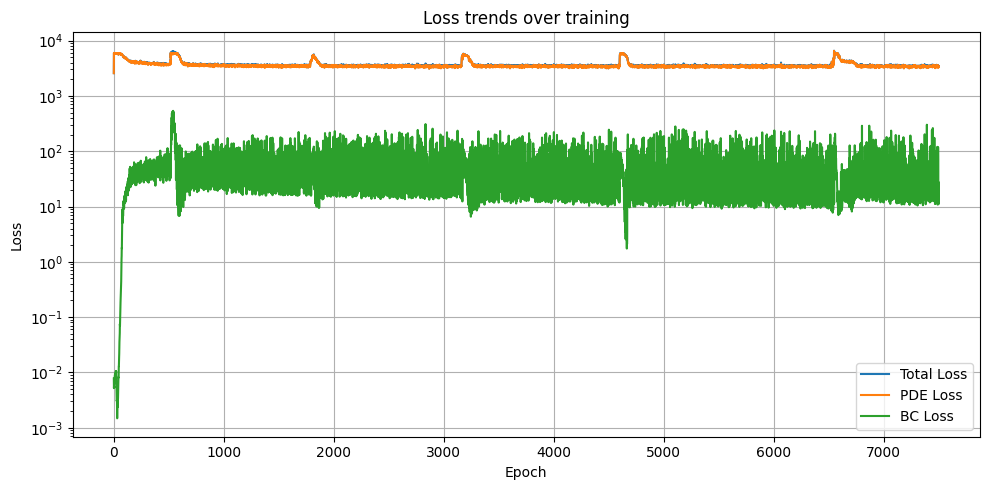


✅ Training complete: 7501 epochs
⏱ Average time per epoch: 0.0113 seconds


In [13]:
# 8
PINN_ReLU_60 = PINN_ReLU_60().to(device)
train_plot(PINN_ReLU_60, epochs = 50000)

torch.save(PINN_ReLU_60.state_dict(), "PINN_ReLU_60.pth")

[Adam] Epoch 0 - Total: 2.54e+03 | PDE: 2.54e+03 | BC: 1.91e-02
[Adam] Epoch 500 - Total: 5.82e+02 | PDE: 5.75e+02 | BC: 6.74e+00
[Adam] Epoch 1000 - Total: 5.09e+00 | PDE: 3.68e+00 | BC: 1.41e+00
[Adam] Epoch 1500 - Total: 3.01e+00 | PDE: 1.86e+00 | BC: 1.15e+00
[Adam] Epoch 2000 - Total: 2.14e+00 | PDE: 1.13e+00 | BC: 1.01e+00
[Adam] Epoch 2500 - Total: 2.04e+00 | PDE: 1.17e+00 | BC: 8.62e-01
[Adam] Epoch 3000 - Total: 1.27e+00 | PDE: 5.22e-01 | BC: 7.50e-01
[Adam] Epoch 3500 - Total: 2.71e+00 | PDE: 2.09e+00 | BC: 6.15e-01
[Adam] Epoch 4000 - Total: 8.88e-01 | PDE: 3.17e-01 | BC: 5.72e-01
[Adam] Epoch 4500 - Total: 8.29e-01 | PDE: 2.73e-01 | BC: 5.56e-01
[Adam] Epoch 5000 - Total: 7.35e-01 | PDE: 2.36e-01 | BC: 5.00e-01
[Adam] Epoch 5500 - Total: 8.50e-01 | PDE: 3.58e-01 | BC: 4.92e-01
[Adam] Epoch 6000 - Total: 6.45e-01 | PDE: 1.93e-01 | BC: 4.51e-01
[Adam] Epoch 6500 - Total: 5.59e-01 | PDE: 1.68e-01 | BC: 3.90e-01
[Adam] Epoch 7000 - Total: 7.83e-01 | PDE: 4.35e-01 | BC: 3.48e-01

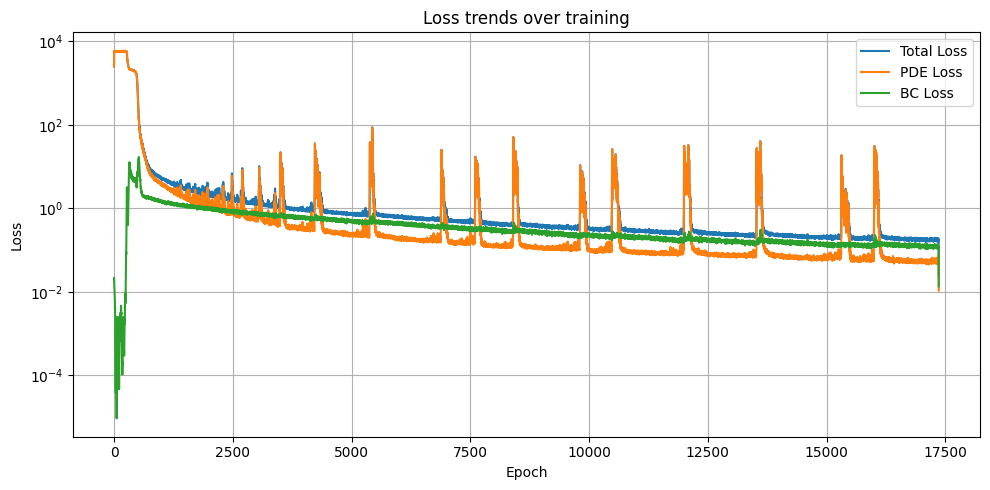


✅ Training complete: 17364 epochs
⏱ Average time per epoch: 0.0199 seconds


In [14]:
# 9
PINN_SiLU_60 = PINN_SiLU_60().to(device)
train_plot(PINN_SiLU_60, epochs = 50000)

torch.save(PINN_SiLU_60.state_dict(), "PINN_SiLU_60.pth")

[Adam] Epoch 0 - Total: 2.46e+03 | PDE: 2.46e+03 | BC: 1.08e-02
[Adam] Epoch 500 - Total: 2.40e+01 | PDE: 2.11e+01 | BC: 2.92e+00
[Adam] Epoch 1000 - Total: 9.41e+00 | PDE: 8.35e+00 | BC: 1.06e+00
[Adam] Epoch 1500 - Total: 4.61e+00 | PDE: 4.07e+00 | BC: 5.34e-01
[Adam] Epoch 2000 - Total: 3.45e+00 | PDE: 2.96e+00 | BC: 4.81e-01
[Adam] Epoch 2500 - Total: 2.99e+00 | PDE: 2.57e+00 | BC: 4.18e-01
[Adam] Epoch 3000 - Total: 2.66e+00 | PDE: 2.25e+00 | BC: 4.08e-01
[Adam] Epoch 3500 - Total: 3.25e+00 | PDE: 2.81e+00 | BC: 4.39e-01
[Adam] Epoch 4000 - Total: 1.78e+00 | PDE: 1.36e+00 | BC: 4.16e-01
[Adam] Epoch 4500 - Total: 1.87e+00 | PDE: 1.44e+00 | BC: 4.35e-01
[Adam] Epoch 5000 - Total: 3.92e+00 | PDE: 3.49e+00 | BC: 4.26e-01
[Adam] Epoch 5500 - Total: 2.28e+00 | PDE: 1.85e+00 | BC: 4.35e-01
[Adam] Epoch 6000 - Total: 1.58e+00 | PDE: 1.17e+00 | BC: 4.12e-01
[Adam] Epoch 6500 - Total: 6.59e+00 | PDE: 6.18e+00 | BC: 4.05e-01
[Adam] Epoch 7000 - Total: 1.81e+00 | PDE: 1.38e+00 | BC: 4.32e-01

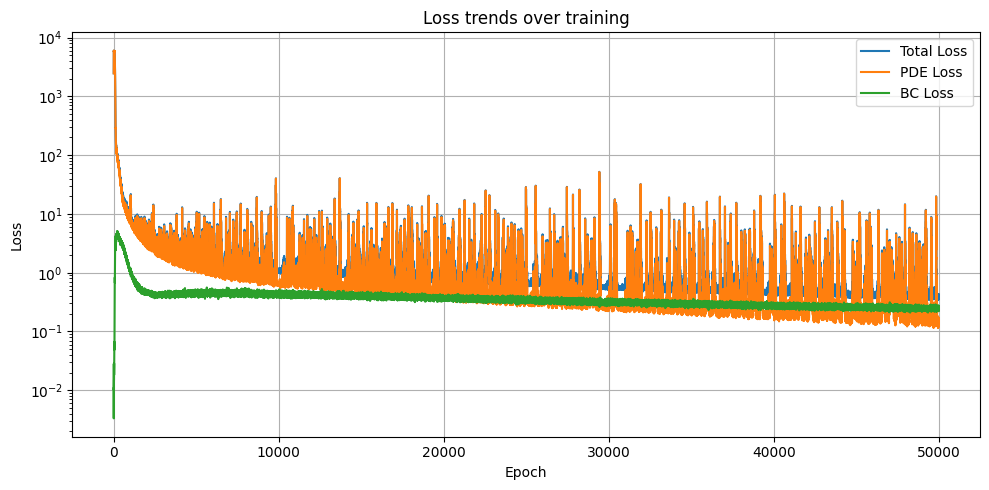


✅ Training complete: 50000 epochs
⏱ Average time per epoch: 0.0141 seconds


In [15]:
# 10
PINN_Sine_60 = PINN_Sine_60().to(device)
train_plot(PINN_Sine_60, epochs = 50000)

torch.save(PINN_Sine_60.state_dict(), "PINN_Sine_60.pth")

[Adam] Epoch 0 - Total: 2.46e+03 | PDE: 2.46e+03 | BC: 6.87e-03
[Adam] Epoch 500 - Total: 3.88e+03 | PDE: 3.60e+03 | BC: 2.78e+02
[Adam] Epoch 1000 - Total: 2.82e+03 | PDE: 2.81e+03 | BC: 3.38e+00
[Adam] Epoch 1500 - Total: 2.57e+03 | PDE: 2.56e+03 | BC: 5.88e+00
[Adam] Epoch 2000 - Total: 1.24e+03 | PDE: 1.24e+03 | BC: 1.00e+00
[Adam] Epoch 2500 - Total: 2.79e+03 | PDE: 2.78e+03 | BC: 8.69e+00
[Adam] Epoch 3000 - Total: 3.40e+03 | PDE: 3.39e+03 | BC: 5.68e+00
[Adam] Epoch 3500 - Total: 3.21e+03 | PDE: 3.20e+03 | BC: 5.12e+00
[Adam] Epoch 4000 - Total: 2.01e+03 | PDE: 2.00e+03 | BC: 5.18e+00
[Adam] Epoch 4500 - Total: 4.04e+02 | PDE: 4.02e+02 | BC: 2.25e+00
[Adam] Epoch 5000 - Total: 6.70e+02 | PDE: 6.69e+02 | BC: 9.82e-01
[Adam] Epoch 5500 - Total: 4.38e+02 | PDE: 4.36e+02 | BC: 1.45e+00
[Adam] Epoch 6000 - Total: 1.19e+03 | PDE: 1.19e+03 | BC: 3.07e+00
[Adam] Epoch 6500 - Total: 1.02e+03 | PDE: 1.01e+03 | BC: 4.76e+00
[Adam] Epoch 7000 - Total: 4.21e+02 | PDE: 4.19e+02 | BC: 2.50e+00

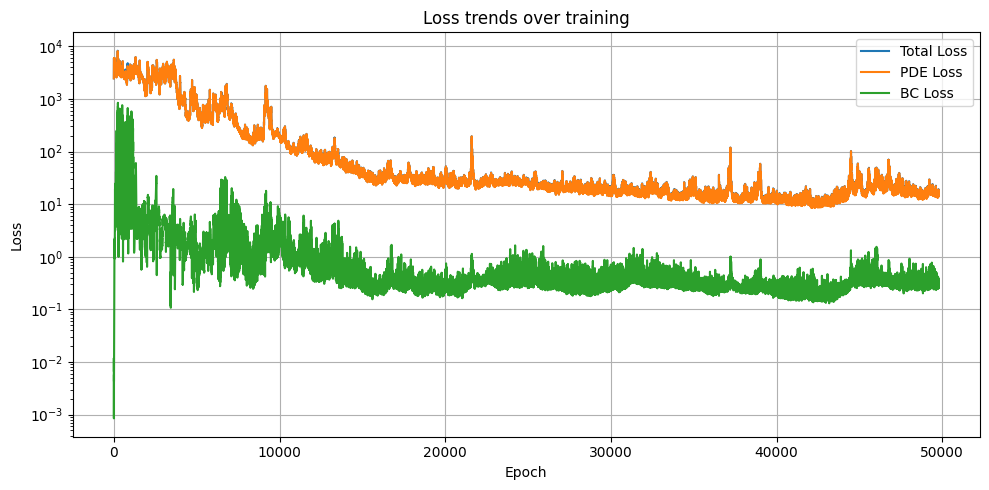


✅ Training complete: 49788 epochs
⏱ Average time per epoch: 0.0154 seconds


In [16]:
# 11
PINN_ELU_60 = PINN_ELU_60().to(device)
train_plot(PINN_ELU_60, epochs = 50000)

torch.save(PINN_ELU_60.state_dict(), "PINN_ELU_60.pth")

[Adam] Epoch 0 - Total: 2.48e+03 | PDE: 2.48e+03 | BC: 4.93e-02
[Adam] Epoch 500 - Total: 1.87e+01 | PDE: 1.41e+01 | BC: 4.63e+00
[Adam] Epoch 1000 - Total: 7.05e+00 | PDE: 3.75e+00 | BC: 3.30e+00
[Adam] Epoch 1500 - Total: 4.66e+00 | PDE: 2.21e+00 | BC: 2.45e+00
[Adam] Epoch 2000 - Total: 3.47e+00 | PDE: 1.79e+00 | BC: 1.69e+00
[Adam] Epoch 2500 - Total: 3.03e+00 | PDE: 1.88e+00 | BC: 1.15e+00
[Adam] Epoch 3000 - Total: 1.58e+00 | PDE: 6.56e-01 | BC: 9.24e-01
[Adam] Epoch 3500 - Total: 1.25e+00 | PDE: 3.94e-01 | BC: 8.59e-01
[Adam] Epoch 4000 - Total: 1.22e+00 | PDE: 3.34e-01 | BC: 8.83e-01
[Adam] Epoch 4500 - Total: 1.06e+00 | PDE: 2.41e-01 | BC: 8.18e-01
[Adam] Epoch 5000 - Total: 1.29e+00 | PDE: 5.28e-01 | BC: 7.67e-01
[Adam] Epoch 5500 - Total: 9.49e-01 | PDE: 2.15e-01 | BC: 7.34e-01
[Adam] Epoch 6000 - Total: 1.27e+00 | PDE: 5.77e-01 | BC: 6.89e-01
[Adam] Epoch 6500 - Total: 1.08e+00 | PDE: 4.72e-01 | BC: 6.10e-01
[Adam] Epoch 7000 - Total: 8.33e-01 | PDE: 1.95e-01 | BC: 6.38e-01

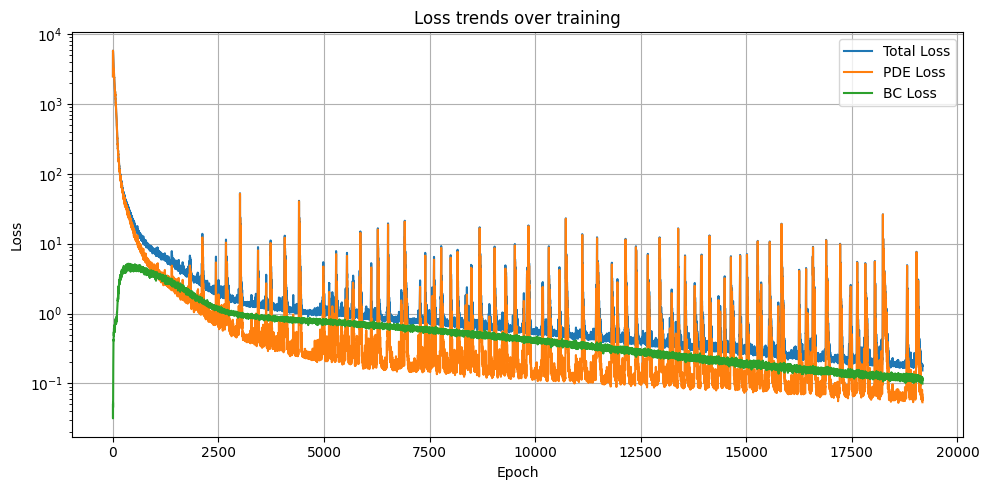


✅ Training complete: 19173 epochs
⏱ Average time per epoch: 0.0411 seconds


In [17]:
# 12
PINN_LN_60 = PINN_LN_60().to(device)
train_plot(PINN_LN_60, epochs = 50000)

torch.save(PINN_LN_60.state_dict(), "PINN_LN_60.pth")

[Adam] Epoch 0 - Total: 2.35e+03 | PDE: 2.35e+03 | BC: 1.53e-04
[Adam] Epoch 500 - Total: 2.46e+01 | PDE: 2.07e+01 | BC: 3.95e+00
[Adam] Epoch 1000 - Total: 8.93e+00 | PDE: 7.82e+00 | BC: 1.12e+00
[Adam] Epoch 1500 - Total: 5.74e+00 | PDE: 5.11e+00 | BC: 6.33e-01
[Adam] Epoch 2000 - Total: 3.91e+00 | PDE: 3.60e+00 | BC: 3.10e-01
[Adam] Epoch 2500 - Total: 3.56e+00 | PDE: 3.34e+00 | BC: 2.15e-01
[Adam] Epoch 3000 - Total: 3.58e+00 | PDE: 3.43e+00 | BC: 1.50e-01
[Adam] Epoch 3500 - Total: 1.84e+00 | PDE: 1.74e+00 | BC: 9.55e-02
[Adam] Epoch 4000 - Total: 2.03e+00 | PDE: 1.97e+00 | BC: 6.50e-02
[Adam] Epoch 4500 - Total: 9.03e-01 | PDE: 8.64e-01 | BC: 3.94e-02
[Adam] Epoch 5000 - Total: 1.14e+00 | PDE: 1.12e+00 | BC: 2.54e-02
[Adam] Epoch 5500 - Total: 6.71e-01 | PDE: 6.54e-01 | BC: 1.67e-02
[Adam] Epoch 6000 - Total: 5.34e-01 | PDE: 5.22e-01 | BC: 1.18e-02
[Adam] Epoch 6500 - Total: 4.65e-01 | PDE: 4.54e-01 | BC: 1.12e-02
[Adam] Epoch 7000 - Total: 4.46e-01 | PDE: 4.36e-01 | BC: 1.00e-02

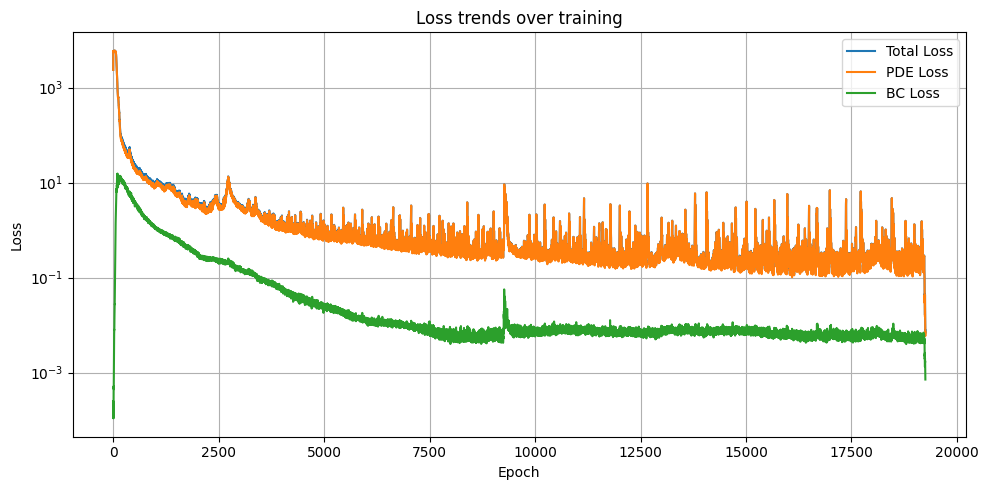


✅ Training complete: 19253 epochs
⏱ Average time per epoch: 0.0229 seconds


In [18]:
# 13
PINN_MixAct = PINN_MixAct().to(device)
train_plot(PINN_MixAct, epochs = 50000)

torch.save(PINN_MixAct.state_dict(), "PINN_MixAct.pth")